In [1]:
import numpy as np
import scipy as sp
import scipy.io as sio

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import tqdm

import scipy.io

from sklearn.decomposition import PCA

C:\Users\vladka\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# original dataset pixels have values in [-1, 1]
# so we need to scale it to use sigmoid in our NN
def normalize(batch):
    batch = batch - np.mean(batch)
    
    pstd = 3*batch.std()
    
    batch[batch >= pstd] = pstd
    batch[batch <= -pstd] = -pstd;
    
    batch /= pstd
    
    batch = (batch+1)*0.4 + 0.1
    
    return batch

def get_random_patch(data, patch_size=8):
    im_num = np.random.randint(0, data.shape[2])
    
    r, c = np.random.randint(0, data.shape[0] - patch_size), np.random.randint(0, data.shape[1] - patch_size)
    
    return data[r:r+patch_size, c:c+patch_size, im_num]

# given data this function returns batch with given size
# patch size defines one dimension of patches that will be selected randomly
# if patch size = 8 , total size of patch would be 8x8 = 64
def get_batch(data, batch_size, patch_size):
    batch = np.zeros((batch_size, patch_size*patch_size), dtype=float)
    
    for i in range(batch_size):
        batch[i] = get_random_patch(data, patch_size).flatten()
        
    return batch

In [3]:
# fully connected layer
# tensor - previous tensor
# w_size - size of the weight matrix, smth like (input size, output size)
# b_size - size of the bias vector, smth like (output_size,)
# name - name of the layer
# activation - activation function, smth like tf.nn.sigmoid
#              for this project we will use sigmoid functions because we want to use KL loss for sparsity 

def create_fc_layer(tensor, w_size, b_size, name, activation):
    r = np.sqrt(6) / np.sqrt(w_size[0] + w_size[1] + 1)

    W = tf.Variable(tf.random_uniform(w_size, minval=-r, maxval=r, dtype=tf.float32), name=name + '.w')
    b = tf.Variable(tf.constant(0., shape=(b_size,), dtype=tf.float32), name=name + 'bias')

    return W, activation(tf.matmul(tensor, W) + b)

# class to represent sparse autoencoder. Trying to give it sklearn-like interface
# num_input - size of the input vector
# num_hidden - size of the hidden layer (only one at this moment)
# max_iters - number of iterations for cost function optimization (only for scipy interface)
# optimizer - optimizer class from tf.train (smth like tf.train.AdamOptimizer)
# lr - learning rate
# beta - coefficient for KL sparse loss
# prob - target probability for activation
# weight_lambda - coefficient for weight regularization
# optim_type = type of optimization, if equals to 'scipy' scipy interface called (for natural images better)
#              otherwise use 'gradient' with optimizer

class SparseAutoencoder(object):
    def __init__(self, num_input, num_hidden, max_iters=500, optimizer=tf.train.AdamOptimizer, lr=0.01,
                 beta=3., prob=0.01, weight_lambda=0.0001, optim_type='gradient'):
        self.num_input = num_input
        self.num_hidden = num_hidden
        self.beta = beta
        self.weight_lambda = weight_lambda
        self.max_iters = max_iters
        self.optim_type = optim_type

        self.sparsity_level = prob

        # model
        self.x = tf.placeholder(tf.float32, [None, self.num_input])
        [self.enc_weights, self.hidden_layer] = create_fc_layer(self.x, (self.num_input, self.num_hidden),
                                                                self.num_hidden,
                                                                name='encoder', activation=tf.nn.sigmoid)

        [self.dec_weights, self.reconstruction] = create_fc_layer(self.hidden_layer, (self.num_hidden, self.num_input),
                                                                  self.num_input, name='decoder',
                                                                  activation=tf.nn.sigmoid)

        self.cost = self.get_sparse_loss()
        
        # dirty! refactor it.
        if self.optim_type == 'scipy':
            self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(
                self.cost,
                method='L-BFGS-B',
                options={'maxiter': max_iters})
        else:
            self.optimizer = optimizer(learning_rate=lr).minimize(self.cost)

        init = tf.global_variables_initializer()
        self.session = tf.Session()
        self.session.run(init)

    def fit(self, X):
        # dirty! refactor it.
        if self.optim_type == 'scipy':
            pbar = tqdm.tqdm_notebook(total=self.max_iters)
            loss_history = list()
            def _update_pbar():
                pbar.update(1)

            self.optimizer.minimize(self.session, feed_dict={self.x: X}, loss_callback=_update_pbar)
        else:
            cost, opt = self.session.run((self.cost, self.optimizer), feed_dict = {self.x: X})
            return cost
    
    def get_sparse_loss(self):
        subj_mse = tf.reduce_sum(tf.pow(self.x - self.reconstruction, 2), axis=1)
        self.mse_loss = 0.5 * tf.reduce_mean(subj_mse)
        
        # sparsity for activation using KL divergence
        p_hat = tf.reduce_mean(self.hidden_layer, axis=0)
        left = self.sparsity_level * tf.log(self.sparsity_level / p_hat)
        right = (1 - self.sparsity_level) * tf.log((1 - self.sparsity_level) / (1 - p_hat))
        self.kl_loss = self.beta * tf.reduce_sum(left + right)
        
        # sparsity for activation using l1 loss
        self.sp_loss = self.weight_lambda * tf.reduce_sum(tf.abs(self.hidden_layer))
        
        # weight regularization. Helps to 'sharpen' features and gives more interpretation to them
        self.reg_loss = self.weight_lambda * (tf.nn.l2_loss(self.enc_weights) + tf.nn.l2_loss(self.dec_weights))
        
        return self.mse_loss + self.reg_loss + self.kl_loss + self.sp_loss

    def calculate_total_cost(self, X):
        return self.session.run(self.cost, feed_dict={self.x: X})

    def calc_mse_loss(self, X):
        return self.session.run(self.mse_loss, feed_dict={self.x: X})

    def calc_kl_loss(self, X):
        return self.session.run(self.kl_loss, feed_dict={self.x: X})
    
    def encode(self, X):
        return self.session.run(self.hidden_layer, feed_dict={self.x: X})

    def reconstruct(self, X):
        return self.session.run(self.reconstruction, feed_dict={self.x: X})

    def get_weights(self):
        return self.session.run(self.enc_weights)


In [10]:
images = sio.loadmat('data/IMAGES.mat')['IMAGES']

In [10]:
patch_size = 8
batch_size = 50000

num_iters = 500

hidden_size = 16

In [12]:
batch = get_batch(images, batch_size, patch_size)
batch = normalize(batch)

In [13]:
m = SparseAutoencoder(patch_size*patch_size, hidden_size, max_iters=num_iters)
m.fit(batch)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.471077
  Number of iterations: 497
  Number of functions evaluations: 528


### Learn basic features from patches

Trying to reproduce results from Bruno A. Olshausen & David J. Field paper. https://www.nature.com/articles/381607a0

I expect to see straight lines with contrast edges.

And the results are similar with paper.

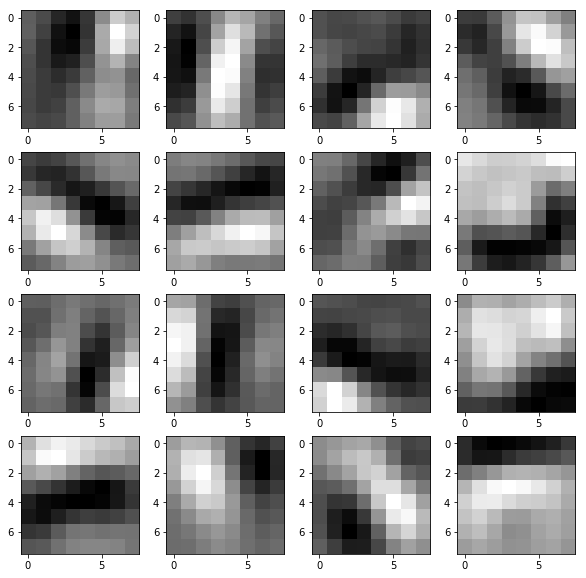

In [14]:
w = m.get_weights()

fig, axes = plt.subplots(4, 4, figsize=(10,10))

for ax, img in zip(axes.flatten(), w.T):
    ax.imshow(img.reshape((8,8)), cmap='gray')

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
mnist_hidden = 64

In [6]:
mnist_imgs, mnist_labels = mnist.train.next_batch(25000)

In [25]:
m = SparseAutoencoder(28*28, mnist_hidden, max_iters=500, prob=0.01)
m.fit(mnist_imgs)

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 15.923552
  Number of iterations: 501
  Number of functions evaluations: 531


[]

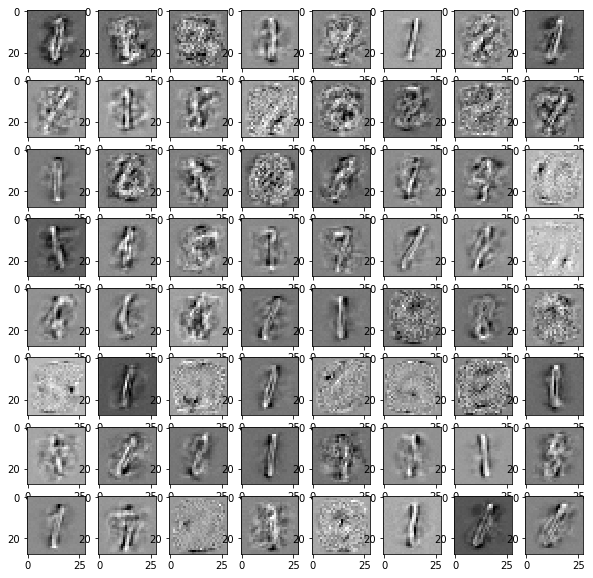

In [28]:
w = m.get_weights()

fig, axes = plt.subplots(8, 8, figsize=(10,10))

for ax, img in zip(axes.flatten(), w.T):
    ax.imshow(img.reshape((28,28)), cmap='gray')

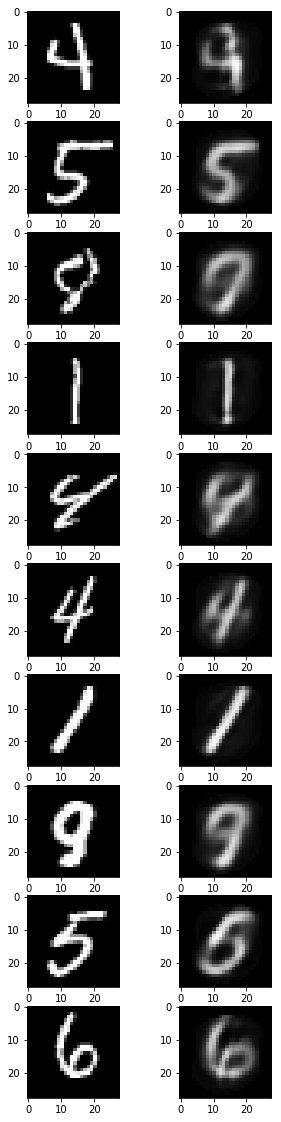

In [27]:
res = m.reconstruct(mnist_imgs[:10])
fig, axes = plt.subplots(10, 2, figsize=(5,20))

for orig, rec, ax in zip(mnist_imgs[:10], res, axes):
    ax[0].imshow(orig.reshape((28,28)), cmap='gray', vmin=0, vmax=1)
    ax[1].imshow(rec.reshape((28,28)), cmap='gray', vmin=0, vmax=1)

In [14]:
encoded = m.encode(mnist_imgs)

In [16]:
encoded_2d = PCA(n_components=2).fit_transform(encoded)

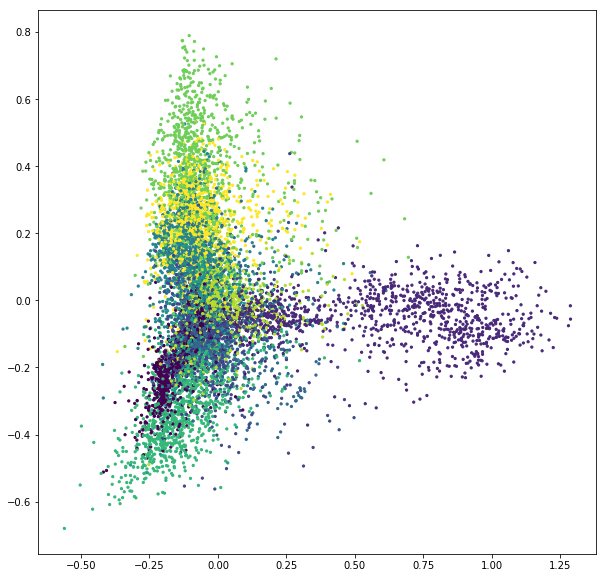

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(encoded_2d[:,0], encoded_2d[:, 1], c=mnist_labels, s=5)

In [109]:
m = SparseAutoencoder(28*28, mnist_hidden, max_iters=500, prob=0.01, weight_lambda=0.0003, optimizer=tf.train.AdamOptimizer, lr=0.01)

In [110]:
for _ in tqdm.tnrange(5000):
    mnist_batch, _ = mnist.train.next_batch(256)
    m.fit(mnist_batch)

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

### Learn from MNIST images

Trying to learn some digits features from MNIST dataset.

I expect to see more complex features than in previous network. Something like curve lines, digits edges etc.

Results are more interesting but looks like some features are noise. 

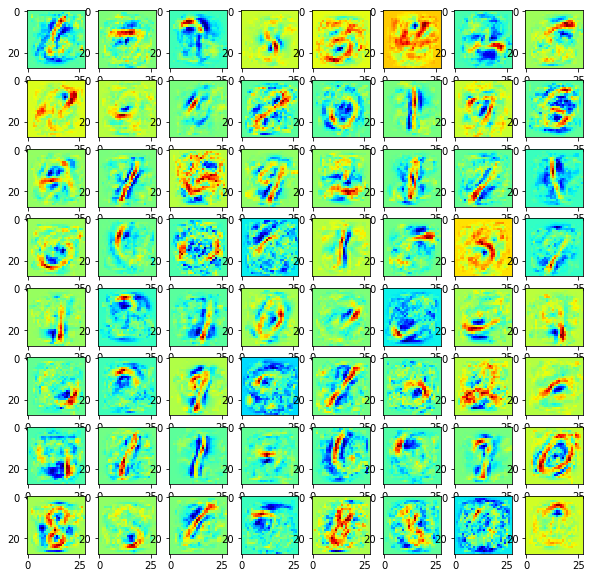

In [111]:
w = m.get_weights()

fig, axes = plt.subplots(8, 8, figsize=(10,10))

for ax, img in zip(axes.flatten(), w.T):
    ax.imshow(img.reshape((28,28)), cmap='jet')

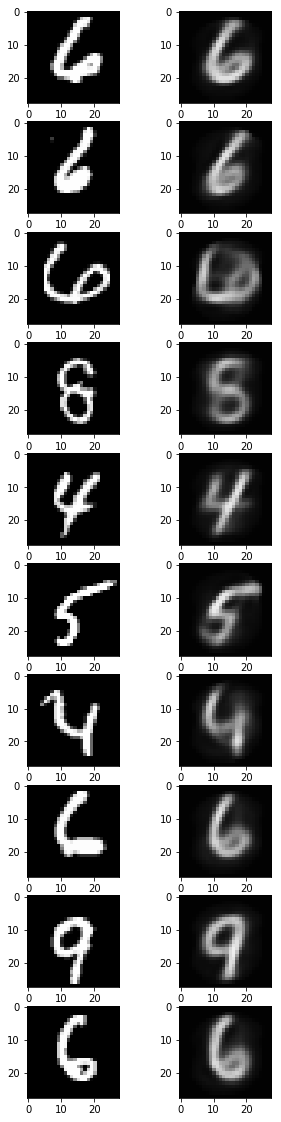

In [112]:
res = m.reconstruct(mnist_batch[:10])
fig, axes = plt.subplots(10, 2, figsize=(5,20))

for orig, rec, ax in zip(mnist_batch[:10], res, axes):
    ax[0].imshow(orig.reshape((28,28)), cmap='gray', vmin=0, vmax=1)
    ax[1].imshow(rec.reshape((28,28)), cmap='gray', vmin=0, vmax=1)